# Lecture 8: Clustering (Unsupervised Classification)

#### This notebook was developed by [Zeljko Ivezic](http://faculty.washington.edu/ivezic/) for the 2023/24 data science class at the Rudjer Boskovic Institute, and it is available from [github](https://github.com/ivezic/RBI2023/blob/main/notebooks/Lecture8.ipynb).


Note: this notebook contains code developed by Z. Ivezic, M. Juric, A. Connolly, B. Sippocz, Jake VanderPlas, G. Richards and many others.


##### Resources for this notebook include:
- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 6.

<a id='toc'></a>
## This notebook includes:
 
[Introduction to Clustering](#intro)
- unsupervised vs. supervised classification
- 1-D hypothesis testing        

[K-means clustering algorithm](#kmeans)

[Clustering with Gaussian Mixture models (GMM)](#gmm)

[Hierarchical clustering algorithm](#hca)

## Introduction to Clustering <a id='intro'></a>
[Go to top](#toc)

### Clustering

“Clustering” in machine learning context refers to a number of different aspects of data analysis. Given a multivariate point data set, we can ask whether it displays any structure, that is, concentrations of points. Alternatively, when a density estimate is available (see Lecture 7), we can search for “overdensities”. Another way to interpret clustering is to seek a partitioning or segmentation of data into smaller parts according to some criteria. 


Here is an illustration of clustering in 2-D space (see Lecture 7 for details):

![](figures/2Dclustering.png)

### Unsupervised vs. Supervised Classification  

In density estimation, we estimate joint probability distributions from multivariate data sets to identify the inherent clustering. This is essentially **unsupervised classification**. Here “unsupervised” means that there is no prior information about the number and properties of clusters.
In other words, this method is search for unknown structure in your (multi-dimensional) dataset.

If we have labels for some of these data points (e.g., an object is tall, short, red, or blue), we can develop a relationship between the label and the properties of a source. This is **supervised classification**. In other words, this method is finding objects in 
your (multi-dimensional) dataset that "look like" objects in your training set. 

Classification, regression, and density estimation are all closely related. For example, the regression function $\hat{y} = f(y|\vec{x})$ is the best estimated value of $y$ given a value of $\vec{x}$. In classification $y$ is categorical and $f(y|\vec{x})$ is called the _discriminant function_
 

##  1-D hypothesis testing
[Go to top](#toc)

How do we decide about the existance of a cluster? Let's start with
the simplest but fundamental example: 1-D hypothesis testing.


### **Motivating question:** 

You just measured x = 3, with a negligible measurement error.

You know that you could have drawn this value from one of two possible populations (e.g. stars and galaxies). One population can be described as N(0,2), and the other one as N(4,1). 

Which population is more likely, given your x?  

###  Naive (wrong) answer: 

3 is closer to 4 (1 "sigma away") than to 0
(1.5 "sigma away") so the second population, N(4,1), is more likely.

#### Let's see why this answer is wrong...
 

![](figures/1Dht.png) 

![](figures/1Dht2.png) 

![](figures/1Dht3.png) 

![](figures/1Dht4.png) 

## K-means clustering algorithm <a id='kmeans'></a>


![](figures/Kmeans.png) 

![](figures/Kmeans2.png) 

## Clustering with Gaussian Mixture models (GMM) <a id='gmm'></a>
[Go to top](#toc)

We already addressed Gaussian Mixture models in Lecture 7 about Density Estimation.

If the clusters can be, at least approximately, described as multi-variate Gaussians, then GMM can be very powerful clustering tool.

Let's first introduce hierarchical clustering algorithm and then we'll compare their
performance on a real data set.


## Hierarchical clustering algorithm <a id='hca'></a>
[Go to top](#toc)

![](figures/hc1.png) 

![](figures/hc2.png) 


### Let's now apply this method to a real dataset: clustering of asteroids in the space of orbital element s



## Clustering of orbital data for asteroids

Asteroids are clustered in orbital parameter space (6 dimensions
but here we will consider two: semi-major axis and inclination)
and these clusters, known as families, are believed to be remnants of larger asteroids destroyed in collisions. Typically, families have
uniform colors, for more details see [Parker et al. 2008.](
http://faculty.washington.edu/ivezic/Publications/parker.pdf)

Using the Parker et al. dataset, available from astroML, we will apply 
Gaussian Mixture Model and the Minimum Spanning Tree model and
compare their clustering results.



### For completeness, we expect structure like this:

![Parker et al. asteroid families](http://faculty.washington.edu/ivezic/sdssmoc/MOC4_population_labels.jpg) 

In [8]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture as GMM

from astroML.clustering import HierarchicalClustering, get_graph_segments
from astroML.datasets import fetch_moving_objects

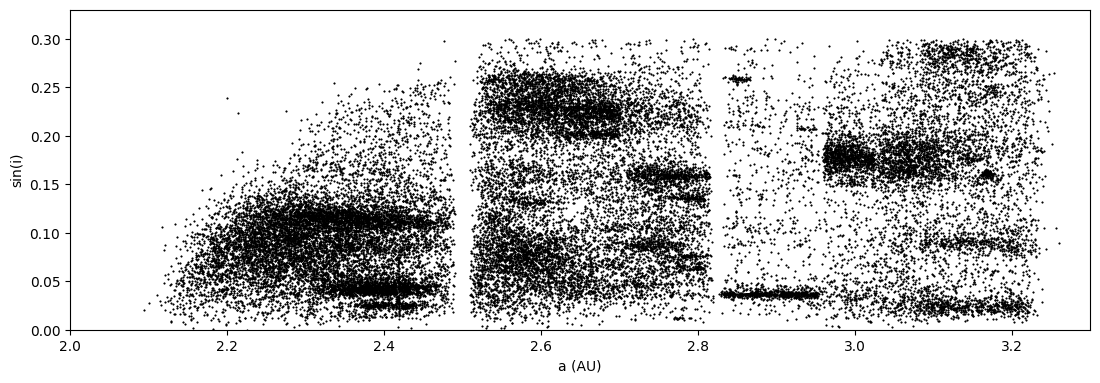

In [9]:
# Fetch data and extract the desired quantities
dataAll = fetch_moving_objects(Parker2008_cuts=True)
data = dataAll[1:]
a = data['aprime']
sini = data['sin_iprime']
acolor = data['mag_a']
izcolor = data['mag_i'] - data['mag_z']
X = np.vstack([a, sini]).T

#------------------------------------------------------------
# Plot 
xmin, xmax = (2.0, 3.3)
ymin, ymax = (0.0, 0.33)
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(hspace=0, left=0.1, right=0.95, bottom=0.1, top=0.9)

ax = fig.add_subplot(311)
ax.scatter(X[:, 0], X[:, 1], s=1, lw=0.5, c='k')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('a (AU)')
ax.set_ylabel('sin(i)')

plt.show()

In [10]:
#------------------------------------------------------------
# Compute GMM models & AIC/BIC
N = np.arange(1, 60)
def compute_GMM(N, covariance_type='full', max_iter=100):
    models = [None for n in N]
    for i in range(len(N)):
        models[i] = GMM(n_components=N[i], max_iter=max_iter,
                        covariance_type=covariance_type)
        models[i].fit(X)
    return models

models = compute_GMM(N)
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]
i_best = np.argmin(BIC)
gmm_best = models[i_best]

print("best fit converged:", gmm_best.converged_)
print("BIC: n_components =  %i" % N[i_best])

best fit converged: True
BIC: n_components =  41


In [11]:
# replaces draw_ellipse from astroML.plotting.tools 
from matplotlib.patches import Ellipse
def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                             (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse((mu[0], mu[1]),
                             2 * scale * sigma1, 2 * scale * sigma2,
                             alpha * 180. / np.pi,
                             **kwargs))

0 12 0.0534477307510588
1 27 0.04875522032474149
2 38 0.04519890122693207
3 3 0.042927562799803934
4 11 0.04214390468794744
5 4 0.03901394027876475
6 2 0.038369227120285336
7 19 0.03487715218066179
8 1 0.0348433040492026
9 13 0.03397381639641221
10 5 0.03255495993143968
11 15 0.030852793324375787
12 28 0.030480766535811908
13 16 0.030398083748160085
14 9 0.030259416384258737
15 24 0.029362793890182304
16 30 0.029135971666956334
17 32 0.02904791886147223
18 25 0.027640690638588643
19 33 0.022177143092016988
20 0 0.022124973812651317
21 39 0.02123292783756196
22 14 0.020069455360148276
23 35 0.01993422419597578
24 21 0.01942570807700579
25 10 0.018621853923444166
26 23 0.017379582399194692
27 26 0.016807173209234184
28 18 0.01591383688290266
29 8 0.015103348249038914
30 40 0.014812882327993116
31 37 0.013866104796714337
32 17 0.013745458499992874
33 29 0.013219085636236683
34 20 0.012561397355254203
35 31 0.011955946863407759
36 6 0.01146669415456199
37 7 0.009727007377616337
38 36 0.003

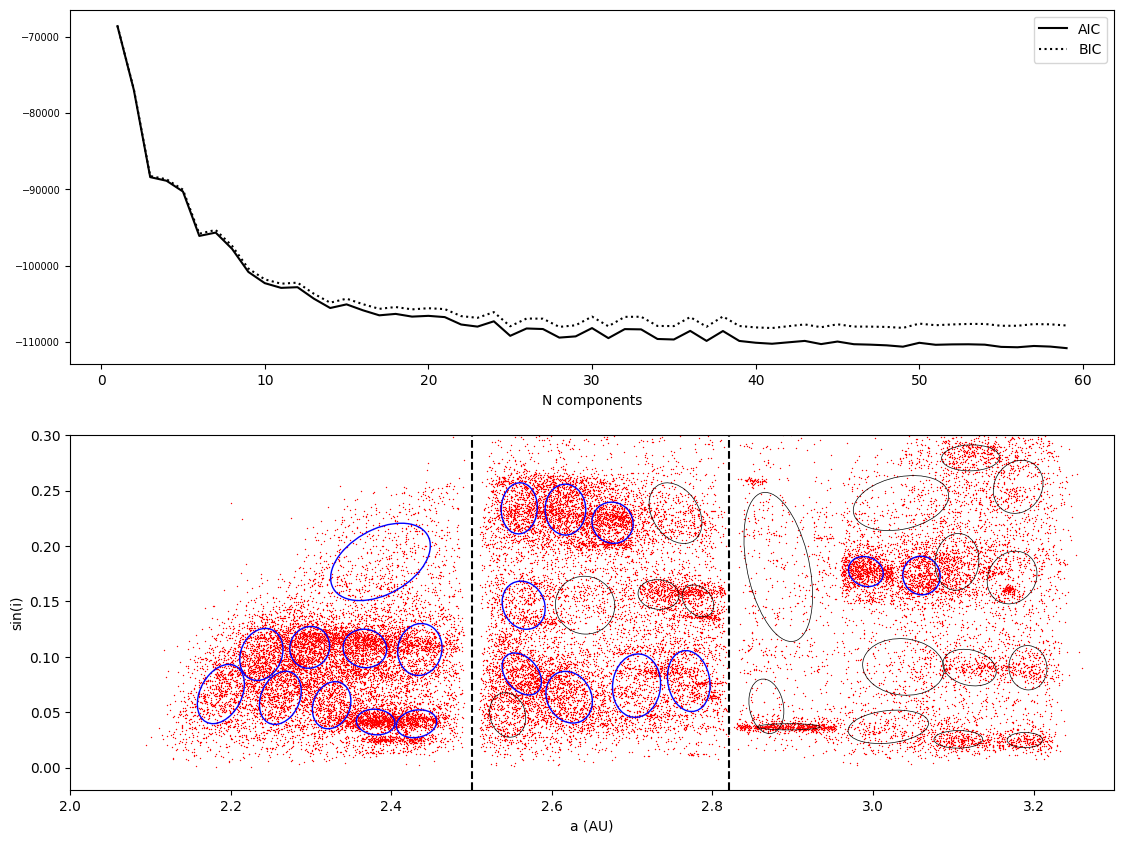

In [12]:
#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(wspace=0.45, bottom=0.25, top=0.9, left=0.1, right=0.97)

# plot AIC/BIC
ax = fig.add_subplot(211)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, ':k', label='BIC')
ax.legend(loc=1)
ax.set_xlabel('N components')
plt.setp(ax.get_yticklabels(), fontsize=7)

# plot best configurations for AIC and BIC
ax = fig.add_subplot(212)

ax.scatter(a, sini, c='red', s=1, lw=0)

ind = np.argsort(gmm_best.weights_)[::-1]
for cnt, i in enumerate(ind[:N[i_best]]):
    mu = gmm_best.means_[i]
    C = gmm_best.covariances_[i]
    w = gmm_best.weights_[i]
    print(cnt, i, w)
    # the 20 most numerous clusters in blue
    if (cnt<20):
        draw_ellipse(mu, C, scales=[1.0], ax=ax, fc='none', lw=1.0, ec='blue')
    else:
        draw_ellipse(mu, C, scales=[1.0], ax=ax, fc='none', lw=0.5, ec='k')
 
ax.plot([2.5, 2.5], [-0.02, 0.3], '--k')
ax.plot([2.82, 2.82], [-0.02, 0.3], '--k')

ax.set_xlim(2.0, 3.3)
ax.set_ylim(-0.02, 0.3)

ax.set_xlabel('a (AU)')
ax.set_ylabel('sin(i)')

plt.show()

### What do you conclude about these GMM results?


In [13]:
#------------------------------------------------------------
# Compute the Minimum Spanning Tree clustering model
n_neighbors = 10
edge_cutoff = 0.9
cluster_cutoff = 10
model = HierarchicalClustering(n_neighbors=10, edge_cutoff=edge_cutoff,
                               min_cluster_size=cluster_cutoff)
model.fit(X)
print(" scale: %2g" % np.percentile(model.full_tree_.data,
                                        100 * edge_cutoff))
n_components = model.n_components_
labels = model.labels_
#------------------------------------------------------------
# Get the x, y coordinates of the beginning and end of each line segment
T_x, T_y = get_graph_segments(model.X_train_,
                              model.full_tree_)
T_trunc_x, T_trunc_y = get_graph_segments(model.X_train_,
                                          model.cluster_graph_)

 scale: 0.00319149


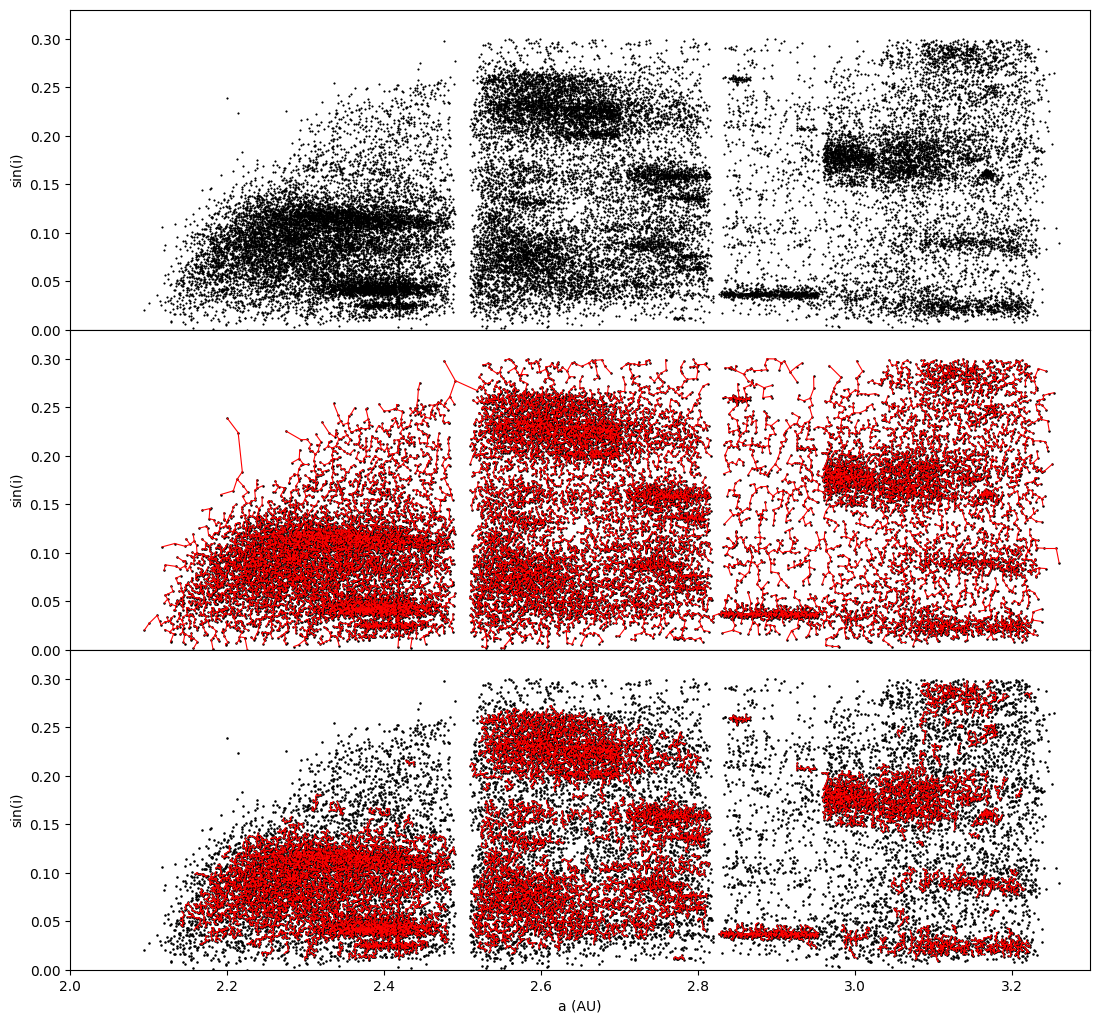

In [14]:
#------------------------------------------------------------
# Plot the results
xmin, xmax = (2.0, 3.3)
ymin, ymax = (0.0, 0.33)
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(hspace=0, left=0.1, right=0.95, bottom=0.1, top=0.9)

ax = fig.add_subplot(311)
ax.scatter(X[:, 0], X[:, 1], s=1, lw=0.5, c='k')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylabel('sin(i)')

ax = fig.add_subplot(312)
ax.scatter(X[:, 0], X[:, 1], s=1, lw=0.8, c='k')
ax.plot(T_x, T_y, c='red', lw=0.8)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylabel('sin(i)')

ax = fig.add_subplot(313)
ax.scatter(X[:, 0], X[:, 1], s=1, lw=0.8, c='k')
ax.plot(T_trunc_x, T_trunc_y, c='red', lw=0.8)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('a (AU)')
ax.set_ylabel('sin(i)')

plt.show()

### What do you conclude about these results? How do they compare to GMM results? 

#### Note: we could now, on per object basis, compare the two classifications into background and clustered objects and somehow (depending on application) combine them into the final classification. 
